# Figure 3. E18 Mouse Brain(10x Multi-omics Data)

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import scanpy as sc
import scvelo as scv
import plotly.graph_objects as go

# 导入您的核心算法模块
from steer import us_transition_matrix, velocity_graph

warnings.filterwarnings('ignore')

# ============================================================================
# 1. Configuration & Global Settings
# ============================================================================
BASE_DIR = '/nvme/users/liuzhy/Review_Files/NoteBook_Main_Figures'
DATA_PATH = os.path.join(BASE_DIR, 'Data4NoteBook', 'Figure3_MouseBrain.adata')
RESULT_PATH = os.path.join(BASE_DIR, 'Results_Figure3')

os.makedirs(RESULT_PATH, exist_ok=True)

# --- Plotting Settings ---
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sc.settings.figdir = RESULT_PATH
sc.settings.plot_prefix = ""

scv.settings.figdir = RESULT_PATH
scv.settings.plot_prefix = ""
scv.set_figure_params(
    style='scvelo',
    dpi=300,
    fontsize=7,
    figsize=(5, 4),
    frameon=True,
    transparent=True
)

# ============================================================================
# 2. Helper Functions
# ============================================================================
def hex_to_rgba(hex_color, opacity):
    """Convert hex color to rgba color with the given opacity."""
    hex_color = hex_color.lstrip('#')
    hlen = len(hex_color)
    rgb = tuple(int(hex_color[i:i+hlen//3], 16) for i in range(0, hlen, hlen//3))
    return f'rgba({rgb[0]},{rgb[1]},{rgb[2]},{opacity})'

def plot_sankey_from_anndata(
    adata, left_label_col, right_label_col, title="Sankey Diagram", 
    output_path=None, left_label_order=None, right_label_order=None,
    left_colors=None, right_colors=None
):
    """Creates a Sankey diagram based on two categorical labels from an AnnData object."""
    left_labels = adata.obs[left_label_col].astype(str)
    right_labels = adata.obs[right_label_col].astype(str)

    unique_left_labels = left_label_order if left_label_order else left_labels.unique().tolist()
    unique_right_labels = right_label_order if right_label_order else right_labels.unique().tolist()

    df = pd.DataFrame({left_label_col: left_labels, right_label_col: right_labels})
    flow_data = df.groupby([left_label_col, right_label_col]).size().reset_index(name='count')

    left_label_index_map = {label: idx for idx, label in enumerate(unique_left_labels)}
    right_label_index_map = {label: idx + len(unique_left_labels) for idx, label in enumerate(unique_right_labels)}

    source = flow_data[left_label_col].map(left_label_index_map).tolist()
    target = flow_data[right_label_col].map(right_label_index_map).tolist()
    value = flow_data['count'].tolist()
    labels = unique_left_labels + unique_right_labels

    if not left_colors:
        left_colors_in_data = adata.uns.get(f'{left_label_col}_colors', ['#1f77b4'] * len(unique_left_labels))
        left_colors = [left_colors_in_data.get(l, '#1f77b4') for l in unique_left_labels] if isinstance(left_colors_in_data, dict) else left_colors_in_data

    if not right_colors:
        right_colors_in_data = adata.uns.get(f'{right_label_col}_colors', ['#D3D3D3'] * len(unique_right_labels))
        right_colors = [right_colors_in_data.get(l, '#D3D3D3') for l in unique_right_labels] if isinstance(right_colors_in_data, dict) else right_colors_in_data

    node_colors = left_colors + right_colors
    link_colors = [hex_to_rgba(left_colors[src], 0.5) for src in source]

    fig = go.Figure(data=[go.Sankey(
        arrangement="snap",
        node=dict(
            pad=10, thickness=20, line=dict(color="black", width=0.5),
            label=labels, color=node_colors, hovertemplate='%{label}<extra></extra>'
        ),
        link=dict(
            source=source, target=target, value=value, color=link_colors,
            hovertemplate='Source: %{source.label}<br />Target: %{target.label}<br />Value: %{value}<extra></extra>',
            line=dict(color='rgba(0,0,0,0)', width=0.5)
        )
    )])

    fig.update_layout(
        title_text=title, font_size=7, title_font_size=7,
        plot_bgcolor='white', paper_bgcolor='white',
        width=300, height=300, margin=dict(l=10, r=10, t=40, b=10),
        font=dict(family='Arial', size=7, color='black')
    )

    if output_path:
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        fig.write_image(output_path, format='pdf')
        print(f"Sankey diagram saved to {output_path}")

    return fig

# ============================================================================
# 3. Data Loading & Preprocessing
# ============================================================================
print(f"Loading data from: {DATA_PATH}")
result_adata = sc.read_h5ad(DATA_PATH)

# Normalize Predicted Time strictly between 0 and 1
pred_time = result_adata.obs['Pred Time']
result_adata.obs['Pred Time'] = (pred_time - pred_time.min()) / (pred_time.max() - pred_time.min())

# Define global colors
result_adata.uns['Expert_colors'] = [
    "#8DD3C7", '#1F78B4', "#FFED6F", "#FB8072", "#80B1D3", 
    "#FDB462", "#B3DE69", "#FCCDE5", "#D9D9D9", "#BC80BD"
]

print("Computing US Transition Matrix...")
combined_adata = us_transition_matrix(
    result_adata, 
    velocity_u_key='pred_vu', 
    velocity_s_key='pred_vs', 
    unspliced_key='model_Mu', 
    spliced_key='model_Ms'
)
# Transfer colors to combined_adata
combined_adata.uns['Expert_colors'] = result_adata.uns['Expert_colors']

# ============================================================================
# 4. Velocity Streams (PHATE & UMAP)
# ============================================================================
print("Computing velocity graphs for embeddings...")
bases = ['X_phate_expression', 'X_phate_refine_embed', 'X_umap', 'X_umap_refine_embed']
for basis in bases:
    if basis in combined_adata.obsm:
        velocity_graph(combined_adata, vkey='velocity', xkey='used_Mu_Ms', basis=basis, show_progress_bar=False)

def plot_velocity_streams(adata, bases_pair, colors, save_name):
    """Helper to plot streams for multiple colors and save."""
    for color in colors:
        fig, axes = plt.subplots(1, 2, figsize=(7, 3))
        for i, (basis, title) in enumerate(zip(bases_pair, ['Gene Expression', 'Learned Embedding'])):
            scv.pl.velocity_embedding_stream(
                adata, ax=axes[i], min_mass=1.5, add_margin=0.1, 
                xlabel=basis.split('_')[1].upper() + '1', 
                ylabel=basis.split('_')[1].upper() + '2',
                basis=basis, vkey='velocity', color=color, 
                title=f'Velocity based on {title}', 
                arrow_size=0.7, linewidth=0.7, frameon=True, show=False
            )
        plt.tight_layout()
        save_path = os.path.join(RESULT_PATH, f'{save_name}_{color}.pdf')
        plt.savefig(save_path, format='pdf', dpi=300, bbox_inches='tight')
        plt.show()  # Or plt.close() if running purely in background
        print(f"Saved: {save_path}")

print("Plotting Velocity Streams...")
plot_velocity_streams(
    combined_adata, 
    bases_pair=['X_phate_expression', 'X_phate_refine_embed'], 
    colors=['celltype', 'Expert'], 
    save_name='velocity_phate'
)

plot_velocity_streams(
    combined_adata, 
    bases_pair=['X_umap', 'X_umap_refine_embed'], 
    colors=['celltype', 'Expert'], 
    save_name='velocity_umap'
)

# ============================================================================
# 5. Pseudo-time Distribution
# ============================================================================
print("Plotting Pseudo-time Distributions...")
time_order = ['RG, Astro, OPC', 'IPC', 'V-SVZ', 'Deeper Layer', 'Upper Layer', 'Subplate', 'Ependymal cells']
expert_order = ['7', '4', '0', '5', '3', '1', '2', '9', '6', '8']

fig, axes = plt.subplots(1, 3, figsize=(7, 2.5))
sc.pl.violin(result_adata, ax=axes[0], keys='Pred Time', stripplot=False, inner="box", groupby='celltype', rotation=90, order=time_order, show=False)
sc.pl.violin(result_adata, ax=axes[1], keys='Pred Time', stripplot=False, inner="box", groupby='Expert', rotation=0, order=expert_order, show=False)
sc.pl.embedding(result_adata, ax=axes[2], basis='X_phate_refine_embed', color='Pred Time', color_map='magma', frameon=True, show=False)
axes[2].set_xlabel('PHATE1')
axes[2].set_ylabel('PHATE2')

plt.tight_layout()
time_path = os.path.join(RESULT_PATH, 'Time.pdf')
plt.savefig(time_path, format='pdf', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {time_path}")

# ============================================================================
# 6. Parameter Embeddings (Mathematical Dynamical Process)
# ============================================================================
print("Plotting Parameter Embeddings...")
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
sc.pl.embedding(result_adata, ax=axes[0], basis='X_pca_para_t', color='Expert', title='PC Space based on α, β, γ, t', legend_loc=None, show=False)
sc.pl.embedding(result_adata, ax=axes[1], basis='X_umap_para_embed', color='Expert', title='UMAP Space based on α, β, γ, t', show=False)

axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[1].set_xlabel('UMAP1')
axes[1].set_ylabel('UMAP2')

handles, labels = axes[1].get_legend_handles_labels()
legend = axes[1].legend(handles=handles, labels=labels, title="Expert", loc='right', bbox_to_anchor=(1.17, 0.5))
legend.get_title().set_fontsize('7')

plt.tight_layout()
para_path = os.path.join(RESULT_PATH, 'Expert_para.pdf')
plt.savefig(para_path, format='pdf', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {para_path}")

# ============================================================================
# 7. Sankey Diagram
# ============================================================================
print("Generating Sankey Diagram...")
sankey_fig = plot_sankey_from_anndata(
    result_adata, 
    left_label_col='celltype',
    right_label_col='Expert', 
    title="Celltype to Expert Flow", 
    left_label_order=['RG, Astro, OPC', 'Ependymal cells', 'IPC', 'V-SVZ', 'Deeper Layer', 'Upper Layer', 'Subplate'],
    right_label_order=['7', '0', '4', '5', '3', '1', '9', '2', '6', '8'],
    left_colors=['#d62728', '#9467bd', '#8c564b', '#2ca02c', '#ff7f0e', '#1f77b4', '#e377c2'],
    right_colors=['#FCCDE5', '#8DD3C7', '#80B1D3', '#FDB462', '#FB8072', '#1F78B4', '#BC80BD', '#FFED6F', '#B3DE69', '#D9D9D9'],
    output_path=os.path.join(RESULT_PATH, 'Sankey.pdf')
)
if sankey_fig:
    sankey_fig.show()

# HSC data

Loading HSC data from: /nvme/users/liuzhy/Review_Files/NoteBook_Main_Figures/Data4NoteBook/Figure3_HSC.adata
Computing US Transition Matrix...
Computing velocity graph on UMAP...
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
        Consider computing the graph in an unbiased manner 
        on full expression space by not specifying basis.

computing velocity graph (using 1/128 cores)
    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
Plotting Global Velocity Streams...
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


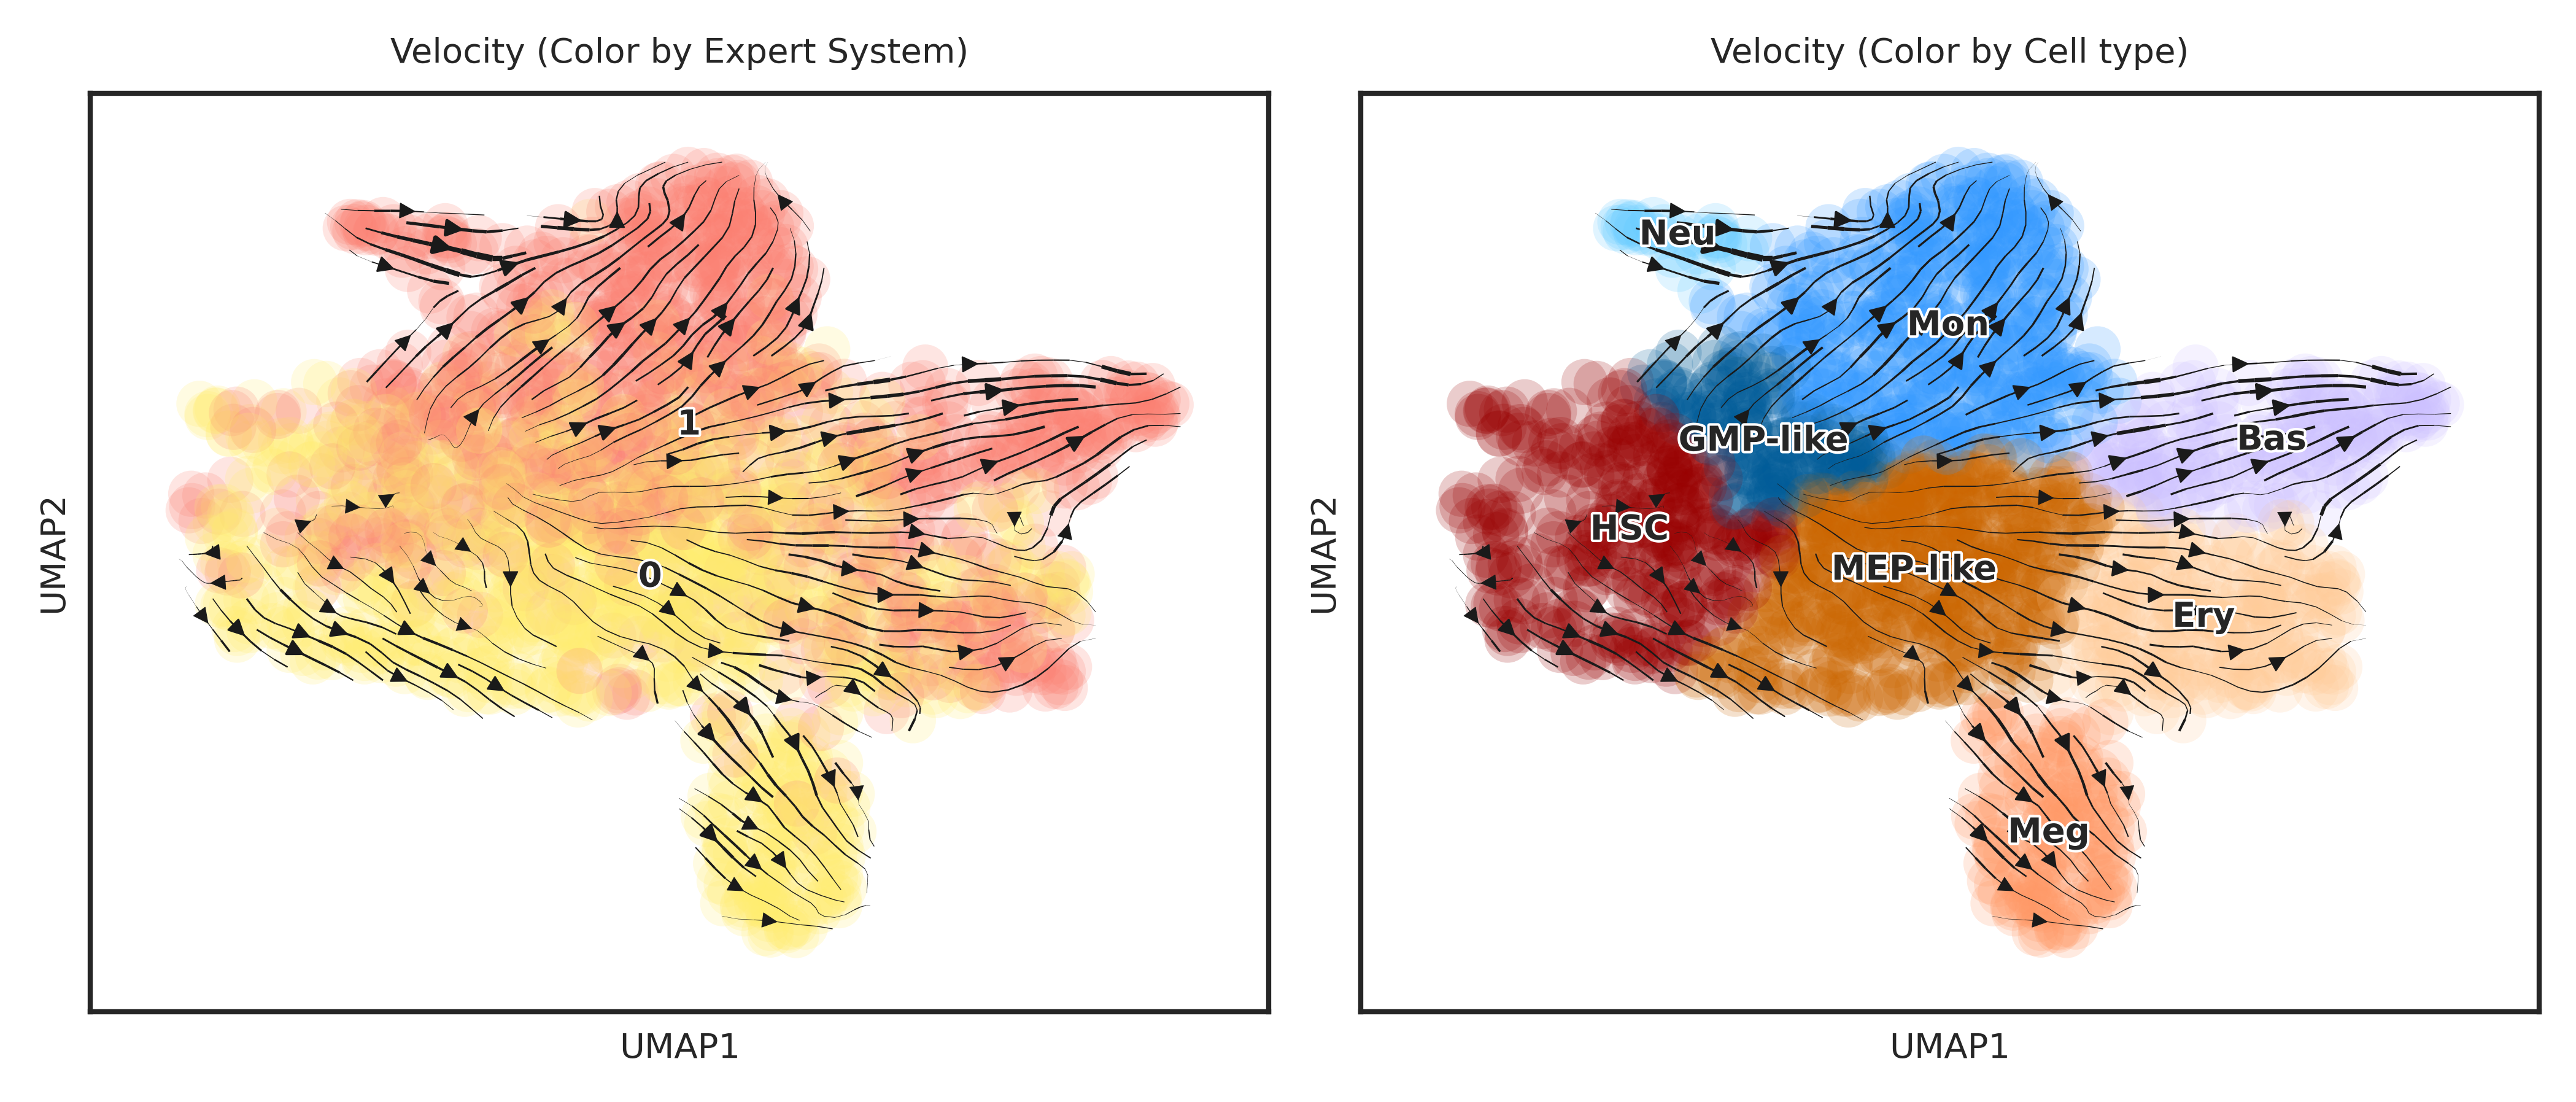

Saved: /nvme/users/liuzhy/Review_Files/NoteBook_Main_Figures/Results_Figure3/UMAP_velo_celltype_expert.png
Plotting Subset Velocity Streams (Expert 0 and 1)...


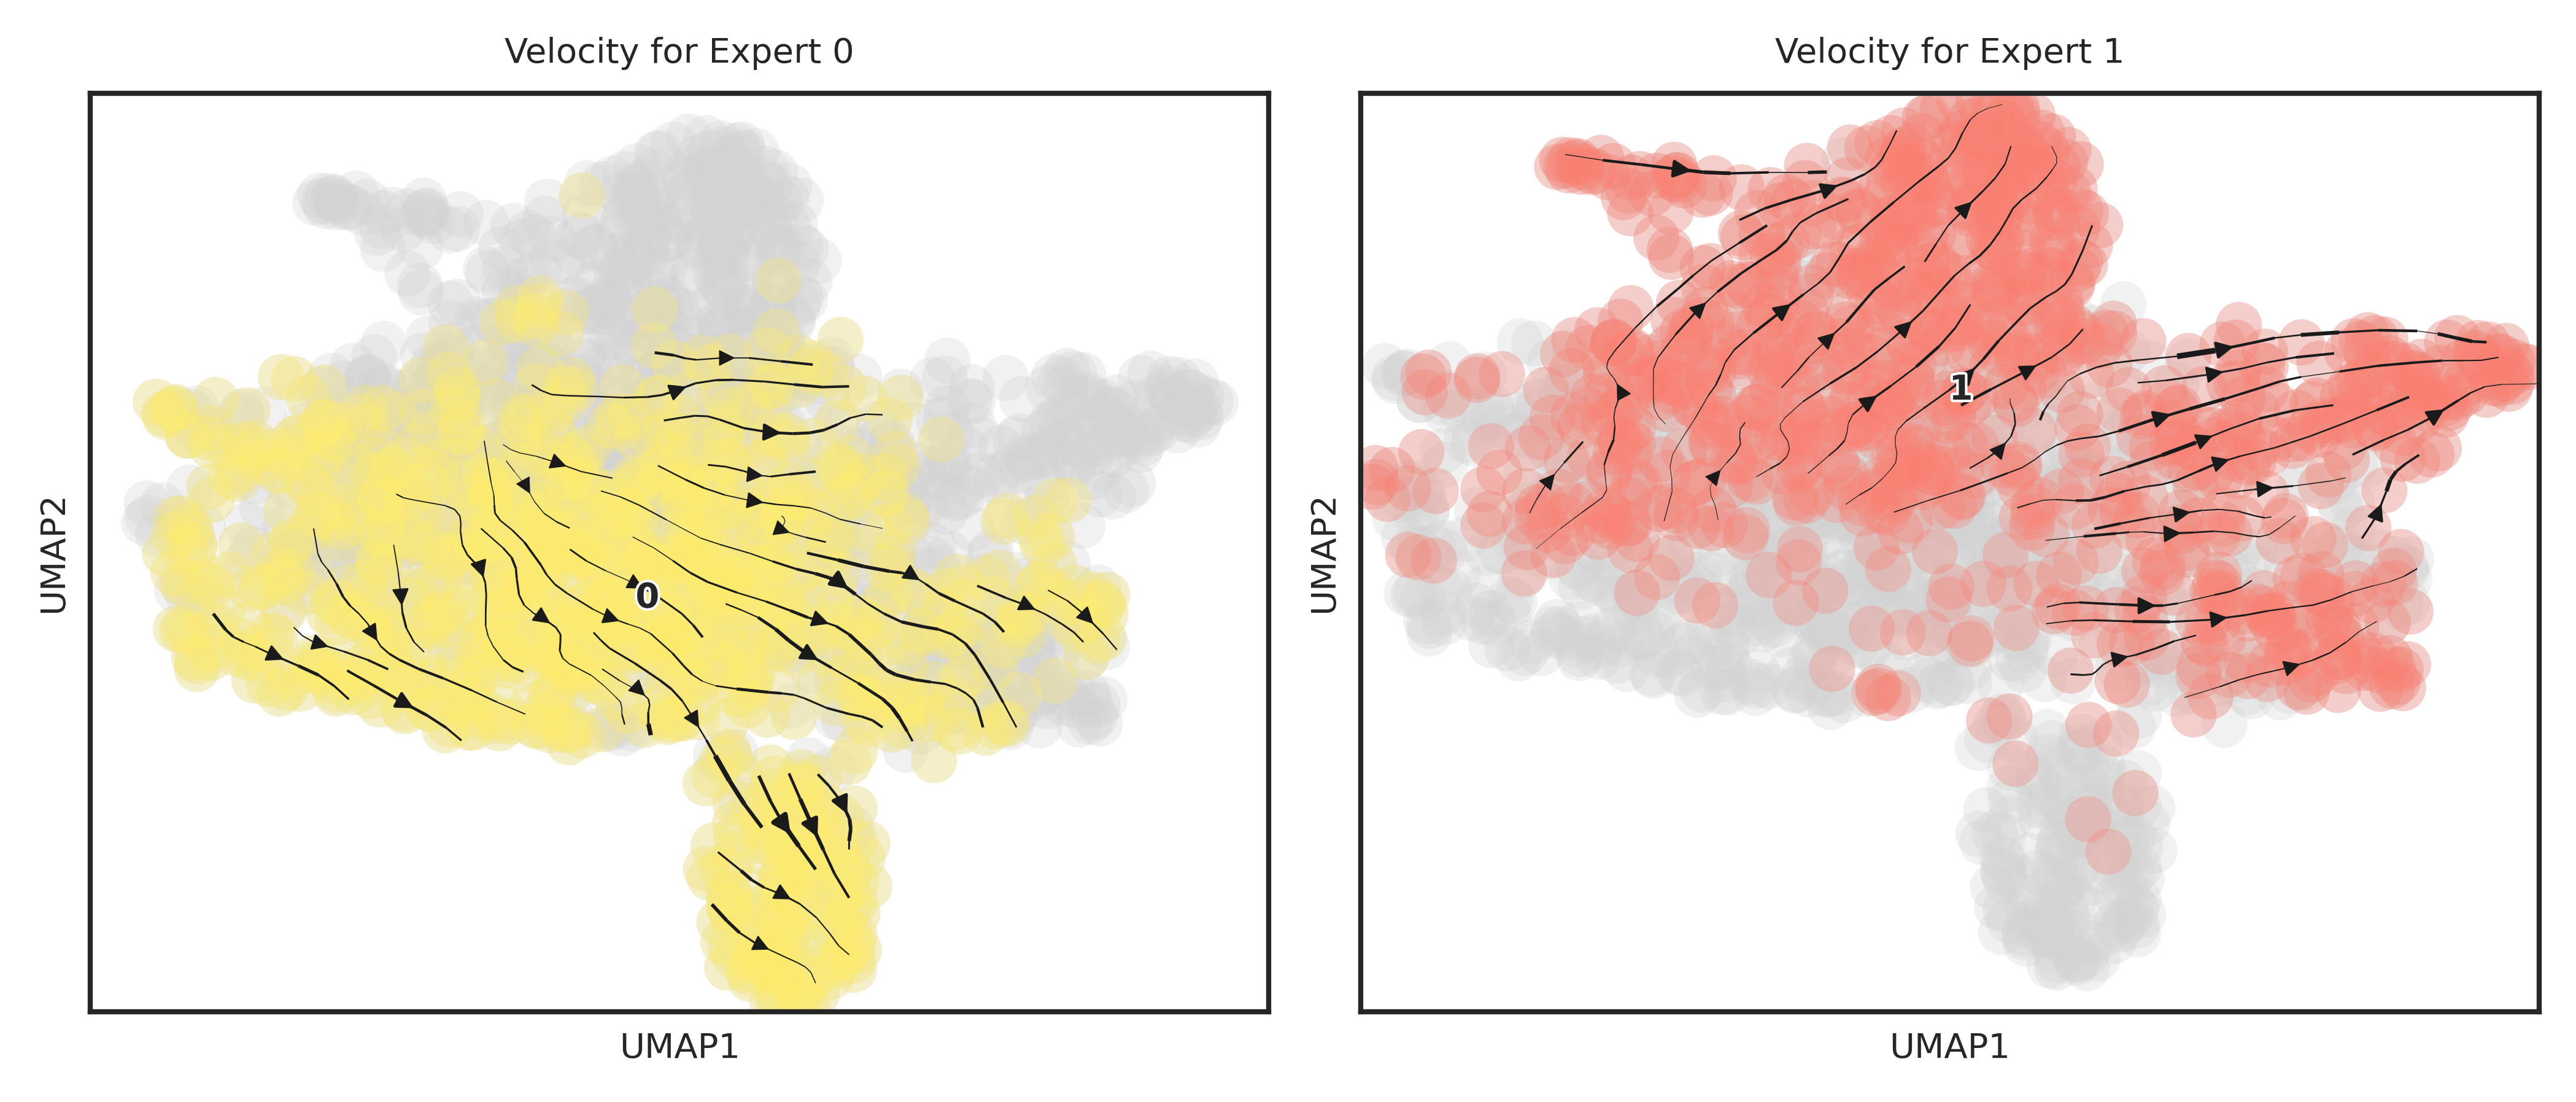

Saved: /nvme/users/liuzhy/Review_Files/NoteBook_Main_Figures/Results_Figure3/UMAP_velo_sub_expert.png
Normalizing pseudo-time and plotting...


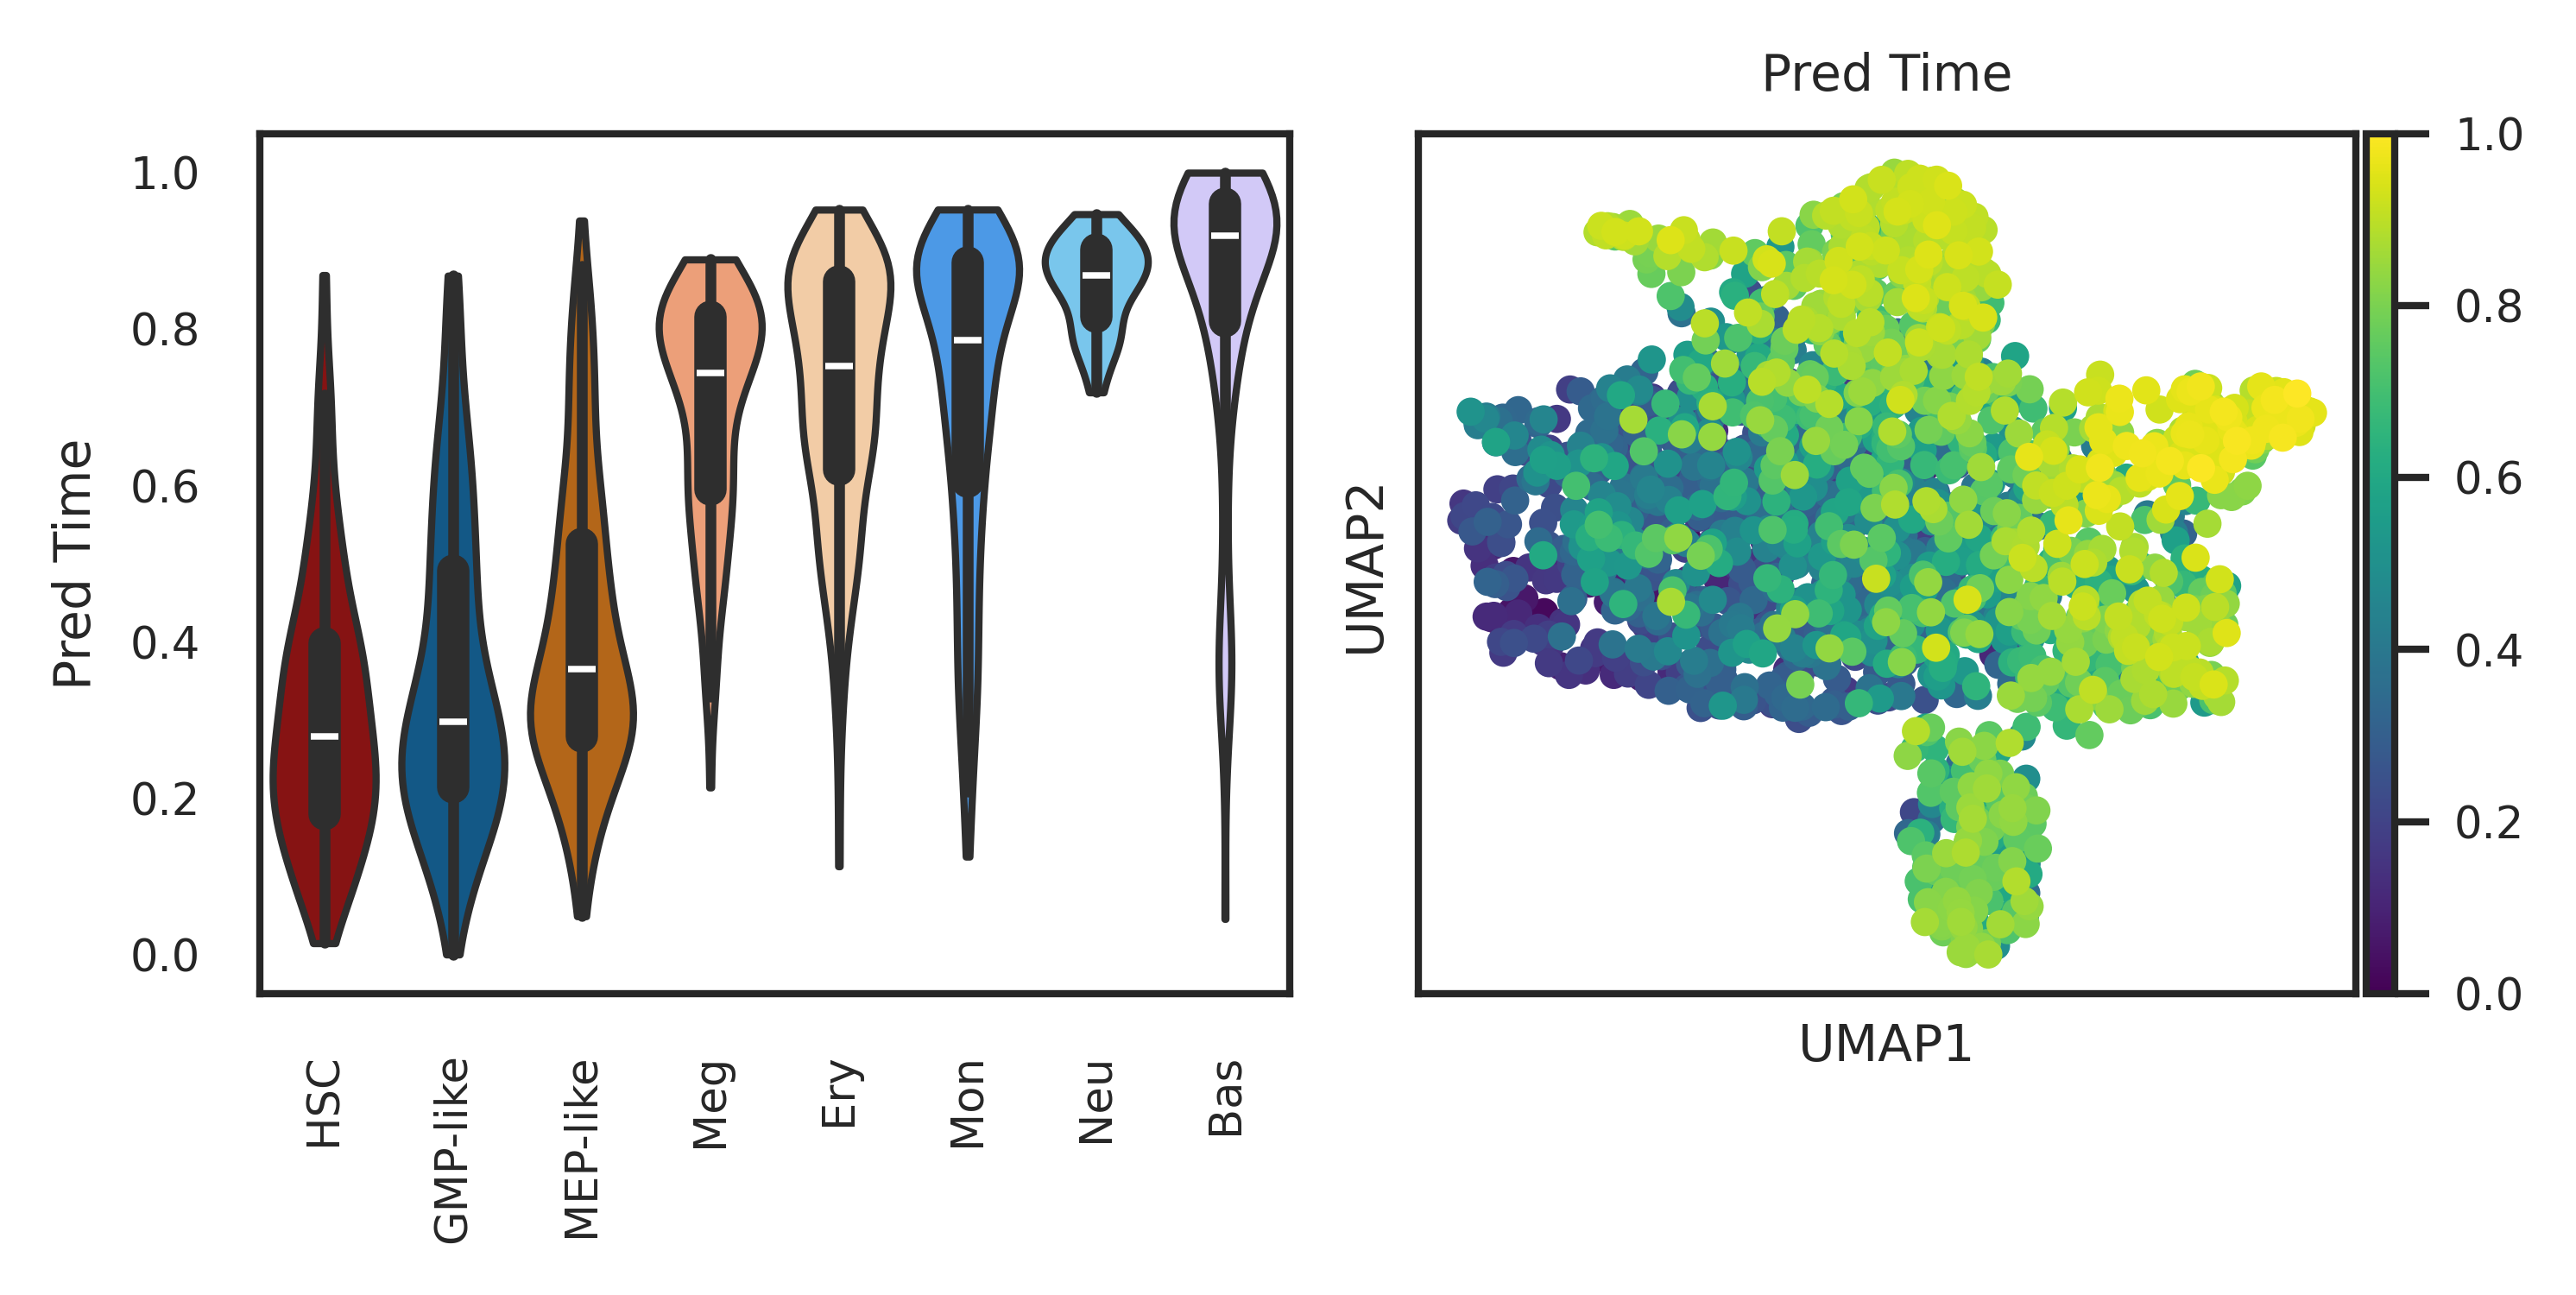

Saved: /nvme/users/liuzhy/Review_Files/NoteBook_Main_Figures/Results_Figure3/Time_show.pdf
✅ Figure 3 (HSC) Generation Complete!


In [3]:
import os
import random
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scanpy as sc
import scvelo as scv
from steer import us_transition_matrix, TimeNorm, velocity_graph

warnings.filterwarnings('ignore')

# ============================================================================
# 1. Configuration & Global Settings
# ============================================================================
BASE_DIR = '/nvme/users/liuzhy/Review_Files/NoteBook_Main_Figures'
DATA_PATH = os.path.join(BASE_DIR, 'Data4NoteBook', 'Figure3_HSC.adata')
RESULT_PATH = os.path.join(BASE_DIR, 'Results_Figure3')

os.makedirs(RESULT_PATH, exist_ok=True)

# Set Reproducibility Seeds
SEED = 618
random.seed(SEED)
np.random.seed(SEED)

# Plotting Settings (Publication Ready)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

scv.settings.figdir = RESULT_PATH
scv.settings.plot_prefix = ""
scv.set_figure_params(
    style='scvelo',
    dpi=300,
    fontsize=7,
    figsize=(3, 3),
    frameon=True,
    transparent=True
)

sns.set_theme(
    context='paper', style='white', font_scale=0.7, 
    rc={"figure.dpi": 300, "axes.titlesize": 7, "axes.labelsize": 7, "legend.fontsize": 6}
)

# ============================================================================
# 2. Data Loading & Preprocessing
# ============================================================================
print(f"Loading HSC data from: {DATA_PATH}")
result_adata = sc.read_h5ad(DATA_PATH)

print("Computing US Transition Matrix...")
combined_adata = us_transition_matrix(
    result_adata, 
    velocity_u_key='pred_vu', 
    velocity_s_key='pred_vs', 
    unspliced_key='model_Mu', 
    spliced_key='model_Ms'
)

# Define and assign colors
celltype_colors = ['#CDC1FF', '#ffcc99', '#005c99', '#990000', '#cc6600', '#ff9966', '#3399ff', '#66ccff']
expert_colors = ["#FFED6F", "#FB8072", "#80B1D3", '#1F78B4', "#8DD3C7"]

combined_adata.uns['celltype_colors'] = celltype_colors
combined_adata.uns['Expert_colors'] = expert_colors
result_adata.uns['Expert_colors'] = expert_colors  # Sync for later use

# Compute Velocity Graph for UMAP
print("Computing velocity graph on UMAP...")
velocity_graph(combined_adata, vkey='velocity', xkey='used_Mu_Ms', basis='X_umap', show_progress_bar=False)

# ============================================================================
# 3. Global Velocity Streams (UMAP)
# ============================================================================
print("Plotting Global Velocity Streams...")
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

scv.pl.velocity_embedding_stream(
    combined_adata, ax=axes[0], min_mass=1.5, add_margin=0.1, alpha=0.2, 
    xlabel='UMAP1', ylabel='UMAP2', basis='X_umap', vkey='velocity', color='Expert',
    title='Velocity (Color by Expert System)', arrow_size=0.7, linewidth=0.7, frameon=True, show=False
)

scv.pl.velocity_embedding_stream(
    combined_adata, ax=axes[1], min_mass=1.5, add_margin=0.1, alpha=0.2, 
    xlabel='UMAP1', ylabel='UMAP2', basis='X_umap', vkey='velocity', color='celltype',
    title='Velocity (Color by Cell type)', arrow_size=0.7, linewidth=0.7, frameon=True, show=False
)

plt.tight_layout()
global_velo_path = os.path.join(RESULT_PATH, 'UMAP_velo_celltype_expert.png')
plt.savefig(global_velo_path, format='pdf', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {global_velo_path}")

# ============================================================================
# 4. Expert-Specific Velocity Subsets
# ============================================================================
# Visualize specific Expert groups (transition matrix is still global)
print("Plotting Subset Velocity Streams (Expert 0 and 1)...")
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

scv.pl.velocity_embedding_stream(
    combined_adata, ax=axes[0], min_mass=4, density=1, arrow_size=0.7, linewidth=0.7, 
    groups='0', xlabel='UMAP1', ylabel='UMAP2', basis='X_umap', vkey='velocity', 
    color='Expert', title='Velocity for Expert 0', show=False
)

scv.pl.velocity_embedding_stream(
    combined_adata, ax=axes[1], min_mass=4, density=1, arrow_size=0.7, linewidth=0.7, 
    groups='1', xlabel='UMAP1', ylabel='UMAP2', basis='X_umap', vkey='velocity', 
    color='Expert', title='Velocity for Expert 1', show=False
)

plt.tight_layout()
sub_velo_path = os.path.join(RESULT_PATH, 'UMAP_velo_sub_expert.png')
plt.savefig(sub_velo_path, dpi=300)
plt.show()
print(f"Saved: {sub_velo_path}")

# ============================================================================
# 5. Pseudo-time Analysis
# ============================================================================
print("Normalizing pseudo-time and plotting...")
result_adata = TimeNorm(result_adata)
time_order = ['HSC', 'GMP-like', 'MEP-like', 'Meg', 'Ery', 'Mon', 'Neu', 'Bas']

fig, axes = plt.subplots(1, 2, figsize=(5, 2.5))

sc.pl.violin(
    result_adata, ax=axes[0], keys='Pred Time', stripplot=False, inner="box",
    groupby='celltype', rotation=90, order=time_order, show=False
)

sc.pl.embedding(
    result_adata, ax=axes[1], basis='X_umap', color='Pred Time', color_map='viridis',
    frameon=True, show=False
)
axes[1].set_xlabel('UMAP1')
axes[1].set_ylabel('UMAP2')

plt.tight_layout()
time_path = os.path.join(RESULT_PATH, 'Time_show.pdf')
plt.savefig(time_path, format='pdf', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {time_path}")

print("✅ Figure 3 (HSC) Generation Complete!")